In [2]:
%load_ext autoreload
%autoreload 2
import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.loss import esp_mono_loss_pots
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())
from dcmnet.utils import apply_model, clip_colors, reshape_dipole
from dcmnet.data import prepare_batches, cut_vdw


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [62]:
plot_model?

Signature: plot_model(DCM2, params, batch, batch_size, nDCM, plot=True)
Docstring: <no docstring>
File:      ~/jaxeq/dcmnet/plotting.py
Type:      function

In [5]:
import time
import numpy as np
from os.path import isfile
from sys import exit,argv
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.constants import physical_constants
import argparse,copy
import pdb
from argparse import RawTextHelpFormatter
from scipy.spatial.transform import Rotation as R
import ase
from dcmnet.electrostatics import batched_electrostatic_potential, calc_esp
import e3x

class cube():
    '''
    Cube Class:
    Includes a bunch of methods to manipulate cube data
    '''

    def __init__(self,fname=None):
        if fname != None:
            try:
                self.read_cube(fname)
            except IOError as e:
                print( "File used as input: %s" % fname )
                print( "File error ({0}): {1}".format(e.errno, e.strerror))
                self.terminate_code()
        else:
            self.default_values()
        return None

    def terminate_code(self):
        print( "Code terminating now")
        exit()
        return None

    def default_values(self):
        self.natoms=0
        self.comment1=0
        self.comment2=0
        self.origin=np.array([0,0,0])
        self.NX=0
        self.NY=0
        self.NZ=0
        self.X=0
        self.Y=0
        self.Z=0
        self.atoms=['0']
        self.atomsXYZ=[0,0,0]
        self.data=[0]
        return None


    def read_cube(self,fname):
        """
        Method to read cube file. Just needs the filename
        """

        with open(fname, 'r') as fin:
            self.filename = fname
            self.comment1 = fin.readline() #Save 1st comment
            self.comment2 = fin.readline() #Save 2nd comment
            nOrigin = fin.readline().split() # Number of Atoms and Origin
            self.natoms = int(nOrigin[0]) #Number of Atoms
            self.origin = np.array([float(nOrigin[1]),float(nOrigin[2]),float(nOrigin[3])]) #Position of Origin
            nVoxel = fin.readline().split() #Number of Voxels
            self.NX = int(nVoxel[0])
            self.X = np.array([float(nVoxel[1]),float(nVoxel[2]),float(nVoxel[3])])
            nVoxel = fin.readline().split() #
            self.NY = int(nVoxel[0])
            self.Y = np.array([float(nVoxel[1]),float(nVoxel[2]),float(nVoxel[3])])
            nVoxel = fin.readline().split() #
            self.NZ = int(nVoxel[0])
            self.Z = np.array([float(nVoxel[1]),float(nVoxel[2]),float(nVoxel[3])])
            self.atoms = []
            self.atomsXYZ = []
            for atom in range(self.natoms):
                line= fin.readline().split()
                self.atoms.append(line[0])
                self.atomsXYZ.append(list(map(float,[line[2], line[3], line[4]])))
            self.data = np.zeros((self.NX,self.NY,self.NZ))
            i= int(0)
            for s in fin:
                for v in s.split():
                    self.data[int(i/(self.NY*self.NZ)), int((i/self.NZ)%self.NY), int(i%self.NZ)] = float(v)
                    i+=1
            # if i != self.NX*self.NY*self.NZ: raise NameError, "FSCK!"
        return None

    def write_cube(self,fname,comment='Cube file written by CubeToolz\nCubeToolz'):
        '''
        Write out a Gaussian Cube file
        '''
        try:
            with open(fname,'w') as fout:
                if len(comment.split('\n')) != 2:
                    print( 'Comment line NEEDS to be two lines!')
                    self.terminate_code()
                fout.write('%s\n' % comment)
                fout.write("%4d %.6f %.6f %.6f\n" % (self.natoms, self.origin[0], self.origin[1], self.origin[2]))
                fout.write("%4d %.6f %.6f %.6f\n" % (self.NX, self.X[0], self.X[1], self.X[2]))
                fout.write("%4d %.6f %.6f %.6f\n" % (self.NY, self.Y[0], self.Y[1], self.Y[2]))
                fout.write("%4d %.6f %.6f %.6f\n" % (self.NZ, self.Z[0], self.Z[1], self.Z[2]))
                for atom,xyz in zip(self.atoms,self.atomsXYZ):
                    fout.write("%s %d %6.3f %6.3f %6.3f\n" % (atom, 0, xyz[0], xyz[1], xyz[2]))
                for ix in range(self.NX):
                   for iy in range(self.NY):
                       for iz in range(self.NZ):
                           fout.write("%.5e " % self.data[ix,iy,iz]),
                           if (iz % 6 == 5): fout.write('\n')
                       fout.write("\n")
        except IOError as e:
            print( "File used as output does not work: %s" % fname)
            print( "File error ({0}): {1}".format(e.errno, e.strerror))
            self.terminate_code()
        return None

    def square_cube(self,power=2):

        '''
        Function to raise cube data to a power. Squares cube data by default.
        '''
        self.data=self.data**power
        print( power )
        return None

    def rotate_cube(self, angle, axes=None):
        '''
        Rotate cube data around a plane. The plane is defined in the axes variable with origin set as point. For example, to rotate along the xy plane, axes would be defined as (0,1).
        '''
        if 0 not in axes:
            rotAxis = 'x'
        elif 1 not in axes:
            rotAxis = 'y'
        elif 2 not in axes:
            rotAxis = 'z'

        # Rotate the atoms
        r = R.from_euler(rotAxis, angle, degrees=True)
        self.atomsXYZ = r.apply(self.atomsXYZ)

        #Centre of new cell
        centreNewCell = np.sum(r.apply([self.X * self.NX, self.Y * self.NY, self.Z * self.NZ]) / 2., axis = 0)

        # Rotate the cube data
        self.data = ndimage.rotate(self.data, angle, axes=axes, mode='wrap')
        self.NX,self.NY,self.NZ = np.shape(self.data)

        # Move atoms' centre of mass to centre of cell
        newCentre = ((self.X * self.NX + self.Y * self.NY + self.Z * self.NZ)) / 2.
        centreDiff = centreNewCell - newCentre

        self.atomsXYZ = self.atomsXYZ - centreDiff

        # Make sure atoms are in cell
        self.atomsXYZ = self.atomsXYZ % (self.X * self.NX + self.Y * self.NY  + self.Z * self.NZ)

        return None


    def translate_cube(self,tVector):
        '''
        Translate cube data by some vector. The vector is given as a list to the tVector function.
        '''
        self.data = ndimage.shift(self.data,tVector,mode='wrap')
        return None

    def planar_average(self,axis):
        '''
        Calculate the planar average along an axis. The axis is given as a string of either x,y or z.
        '''
        bohrA = physical_constants['Bohr radius'][0]*1e10
        vol = np.linalg.det(np.array([self.X, self.Y, self.Z]))
        dx, dy, dz = (self.X + self.Y + self.Z) * bohrA

        if axis == 'x':
            PlanAv = np.array([[ nx * self.X[0] * bohrA, (np.sum(self.data[nx,::]) * vol) / dx] for nx in range(self.NX)])
        elif axis == 'y':
            PlanAv = np.array([[ ny * self.Y[1] * bohrA, (np.sum(self.data[:,ny,:]) * vol) / dy] for ny in range(self.NY)])
        elif axis == 'z':
            PlanAv = np.array([[ nz * self.Z[2] * bohrA, np.sum(self.data[:, :, nz] * vol) / dz] for nz in range(self.NZ)])
        else:
            print( '%s' % 'No axis specified! Planar average will return zero and fail.')
            PlanAv = 0.0
        return PlanAv

    def planar_averageG(self,axis,sigma):
        '''
        Broaden the planar average along an axis. The axis is given as a string of either x,y or z. A broadening value is also needed.
        '''
        PlanAvG = self.planar_average(axis)
        PlanAvG[:,1] = gaussian_filter(PlanAvG[:,1],sigma)
        return PlanAvG

    def cube_int(self):
        '''
        Integrate the entire cube data.
        '''
        angstrom=physical_constants['Bohr radius'][0]*1e10
        vol=np.linalg.det(np.array([self.X,self.Y,self.Z]))
        edensity=np.sum(self.data)
        nelectron=vol*edensity

        #print 'Number of electrons: %.7g' % (nelectron)
        return nelectron


    def cube_int_atom(self, atomID, radius):
        '''
        Integrate the cube data in a sphere around a particular atom. Needs the atom number (note that atom 0 is the first atom). Also needs a radius of the sphere.
        '''
        voxelMatrix = np.array([self.X,self.Y,self.Z])
        radius *= 1 / (physical_constants['Bohr radius'][0] * 1e10)
        vol = np.linalg.det(voxelMatrix)
        atomXYZ = np.array(self.atomsXYZ[atomID]) #+ self.origin

        ZYX = np.ogrid[:self.NX, :self.NY, :self.NZ]
        dZYX = self.Z + self.Y + self.X
        ZYX = ZYX * dZYX

        dist_from_center = np.linalg.norm(ZYX - atomXYZ)
        mask = dist_from_center <= radius

        nelectron = np.sum(mask * self.data * vol)

        return nelectron

    def cube_int_ref(self,ref,radius):
        '''
        Integrate the cube data in a sphere around a point. Also needs the point as a list.
        '''
        voxelMatrix = [self.X,self.Y,self.Z]
        vol = np.linalg.det(voxelMatrix)
        ref = np.array(ref) * (1 / (physical_constants['Bohr radius'][0] * 1e10))
        radius *= 1 / (physical_constants['Bohr radius'][0] * 1e10)

        ZYX = np.array(np.ogrid[:self.NX, :self.NY, :self.NZ], dtype = object)
        dZYX = self.Z + self.Y + self.X
        ZYX *= dZYX


        dist_from_center = np.linalg.norm(ZYX - ref)
        mask = dist_from_center <= radius

        nelectron = np.sum(mask * self.data * vol)


        return nelectron

    def super_cube(self,new_size):
        '''
        Function to make a new cube supercell. Takes in 3D list of how big the supercell should be.
        '''
        cell = np.array((self.NX * self.X, self.NY * self.Y, self.Z * self.NZ))
        new_data = np.zeros([new_size[0]*self.NX,new_size[1]*self.NY,new_size[2]*self.NZ])
        new_xyz = self.atomsXYZ
        n_newcells = np.prod(new_size)
        new_xyz = np.array(tuple(self.atomsXYZ)*n_newcells)
        counter = 0
        for x in range(new_size[0]):
            for y in range(new_size[1]):
                for z in range(new_size[2]):
                        new_data[x*self.NX:(x+1)*self.NX,y*self.NY:(y+1)*self.NY,z*self.NZ:(z+1)*self.NZ] += self.data
                        new_xyz[counter*self.natoms:(counter+1)*self.natoms] = self.atomsXYZ + ( (np.array(cell[0]) * x ) + (np.array(cell[1]) * y) + (np.array(cell[2]) * z))
                        counter += 1
        new_data = transform.rescale(new_data,1/np.mean(new_size),order=3)
        self.data = new_data
        self.X = ((self.NX * self.X) / float(np.shape(new_data)[0])) * new_size[0]
        self.Y = ((self.NY * self.Y) / float(np.shape(new_data)[1])) * new_size[1]
        self.Z = ((self.NZ * self.Z) / float(np.shape(new_data)[2])) * new_size[2]
        self.NX, self.NY, self.NZ = np.shape(new_data)
        self.atomsXYZ = new_xyz
        self.atoms *= len(self.atomsXYZ)
        self.natoms = len(new_xyz)
        return None




In [287]:
# C = cube("/pchem-data/meuwly/boittier/home/jaxeq/eric/fluro/esp_fluro-ben.cube")
C = cube("/pchem-data/meuwly/boittier/home/jaxeq/eric/para-phenol/esp-or-para.0.cube")
C = cube("/pchem-data/meuwly/boittier/home/CubeTools/cubes/butadiene/scan_extract_0.xyz.chk.fchk.pot.cube")
C = cube("/pchem-data/meuwly/boittier/home/MDCM/examples/naptha/ref/naphta.pot.cube")
# C = cube("/pchem-data/meuwly/boittier/home/MDCM/examples/ref/benzene-pot.cube")
# C = cube("/pchem-data/meuwly/boittier/MDCM/examples/methanol/ref/scan0.p.cube")
# C = cube("/pchem-data/meuwly/boittier/MDCM/examples/dimethylether/ref/scan0.p.cube")
P = []
XYZ = []

for ix in range(C.NX):
   for iy in range(C.NY):
       for iz in range(C.NZ):
           P.append(C.data[ix,iy,iz])
           XYZ.append([C.origin[0]+C.X[0] * ix, 
                       C.origin[1]+C.Y[1] * iy, 
                       C.origin[2]+C.Z[2] * iz])

R = np.array(C.atomsXYZ)*0.529177
Z = np.array([int(_) for _ in C.atoms])
XYZ = np.array(XYZ)*0.529177


In [288]:
colors = clip_colors(P)

In [289]:
mask, closest = cut_vdw(XYZ, R, Z)

(-10.0, 10.0)

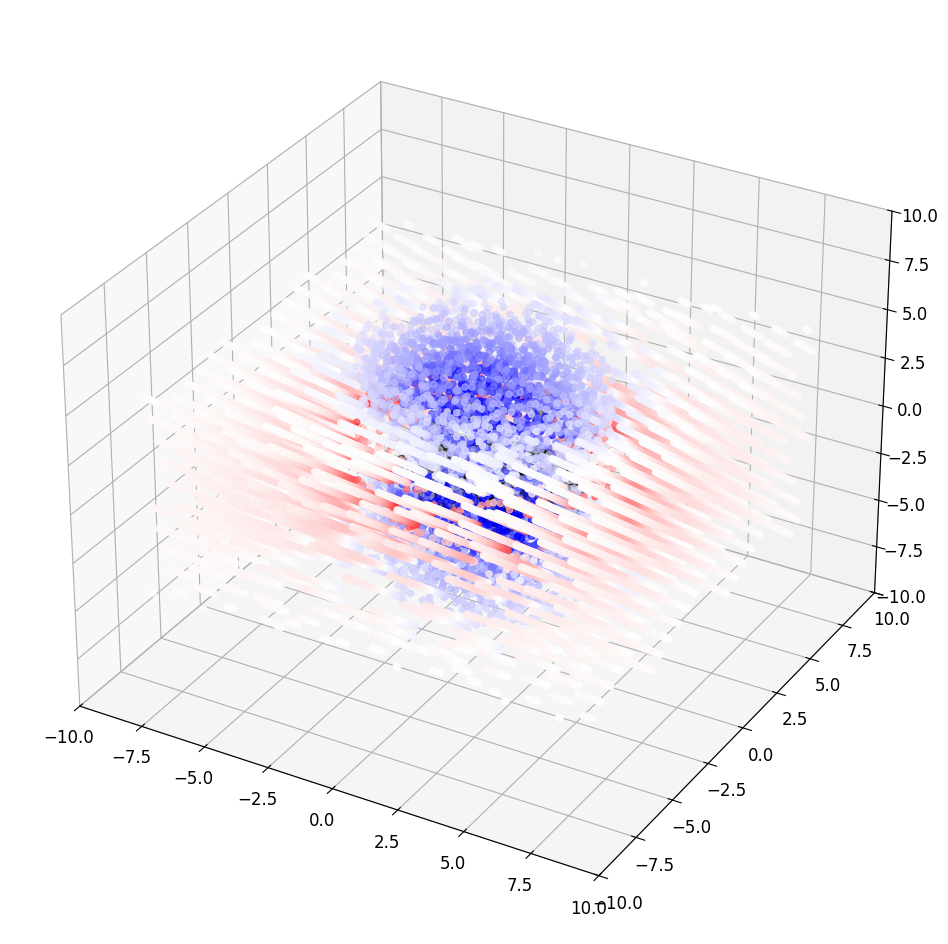

In [290]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(111, projection="3d")

ax1.scatter(*XYZ[mask][::100].T, c=colors[mask][::100])
ax1.scatter(*R.T, c="k", s=1000)

ax1.set_xlim(-10,10)
ax1.set_ylim(-10,10)
ax1.set_zlim(-10,10)

In [291]:


masses = np.array(
    [
        ase.data.atomic_masses[s]
        for s in Z
    ]
)
com = jnp.sum(R * masses[:, None], axis=0) / jnp.sum(masses)

In [292]:
max_N_atoms = 60

In [293]:
# Z = [np.array([ase.data.atomic_numbers[_.capitalize()] for _ in elements[i]]) for i in range(N)]
pad_Z = np.pad(Z, ((0,max_N_atoms - len(Z))))
pad_Z.shape


pad_coords = np.pad(R, ((0,max_N_atoms - len(R)),(0,0)))
pad_coords.shape


(60, 3)

In [294]:
charges = np.array([0.398122,
0.816733,
0.816739,
-0.575908,
0.398108,
-0.634264,
0.537569,
-0.553022,
-0.517699,
0.407229,
-0.517701,
-0.575907,])

charges = np.array( [-0.123293,
  0.021489,
  0.021489,
  0.042838,
 -0.123292,
 -0.552972,
  0.583706,
  0.043331,
  0.069044,
 -0.094222,
  0.069044,
  0.042838,])

pad_charges = np.pad(charges, ((0,max_N_atoms - len(charges))))

In [295]:
data = {"R": np.array([pad_coords]),
       "Z": np.array([pad_Z]),
       "N": np.array([[len(np.nonzero(Z)[0])]]),
       "mono": np.array([pad_charges]),
       "esp": np.array([P]),
        "vdw_surface": np.array([XYZ]),
        "ngrid": np.array([len(P)]),
        "D": np.array([0]),
        "Dxyz": np.zeros(3),
        "espMask": np.array([mask]),
        "com": np.array([com]),
       }

In [296]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)

In [297]:


batch_size = 1
# Prepare entries that are identical for each batch.
num_atoms = 60
batch_segments = jnp.repeat(jnp.arange(batch_size), num_atoms)
offsets = jnp.arange(batch_size) * num_atoms
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(num_atoms)
dst_idx = (dst_idx + offsets[:, None]).reshape(-1)
src_idx = (src_idx + offsets[:, None]).reshape(-1)

output = []
data_keys = [
    "R",
    "Z",
    "N",
    "mono",
    "esp",
    "vdw_surface",
    "n_grid",
    "D",
    "Dxyz",
    "espMask",
    "com",
]


for perm in [0]:
    dict_ = dict()
    for k, v in data.items():
        if k in data_keys:
            if k == "R":
                dict_[k] = v[perm].reshape(-1, 3)
            elif k == "Z":
                dict_[k] = v[perm].reshape(-1)
            elif k == "mono":
                dict_[k] = v[perm].reshape(-1)

            else:
                dict_[k] = v[perm]

    dict_["dst_idx"] = dst_idx
    dict_["src_idx"] = src_idx
    dict_["batch_segments"] = batch_segments
    output.append(dict_)


In [298]:
batch =  output[0]

In [299]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")

In [300]:
files = {_.parents[0].name: _ for _ in list(ddir.glob("test4/*dcm-4*/best*"))}
KEYS = list(files.keys())
for i, _ in enumerate(KEYS):
    print(i, _)

0 20241002-180908dcm-4-w-10000.0-re-True-ptTrue
1 20241002-180930dcm-4-w-10000.0-re-True-ptTrue
2 20241002-180943dcm-4-w-10000.0-re-True-ptTrue
3 20241002-182242dcm-4-w-10000.0-re-True-ptTrue


/pchem-data/meuwly/boittier/home/jaxeq/all_runs/test4/20241002-180908dcm-4-w-10000.0-re-True-ptTrue/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 4.0, 'include_pseudotensors': False, 'debug': False}
MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
    include_pseudotensors = True
)
6.424667e-07
1.53488


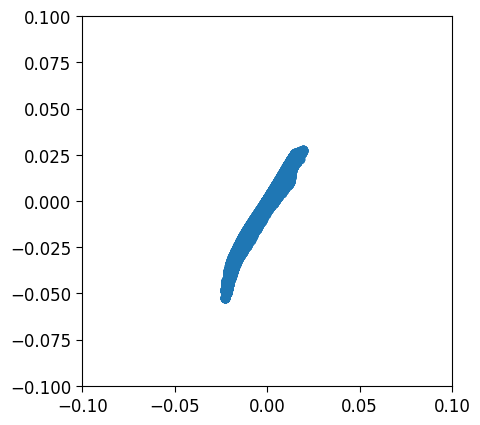

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/test4/20241002-180930dcm-4-w-10000.0-re-True-ptTrue/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 4.0, 'include_pseudotensors': False, 'debug': False}
MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
    include_pseudotensors = True
)
3.0967528e-06
1.1024386


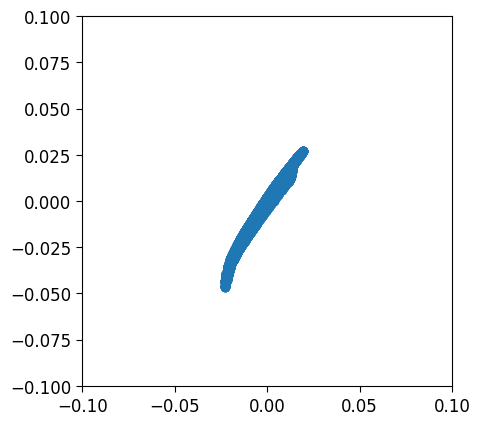

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/test4/20241002-180943dcm-4-w-10000.0-re-True-ptTrue/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 4.0, 'include_pseudotensors': False, 'debug': False}
MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
    include_pseudotensors = True
)
2.3608495e-06
2.4559035


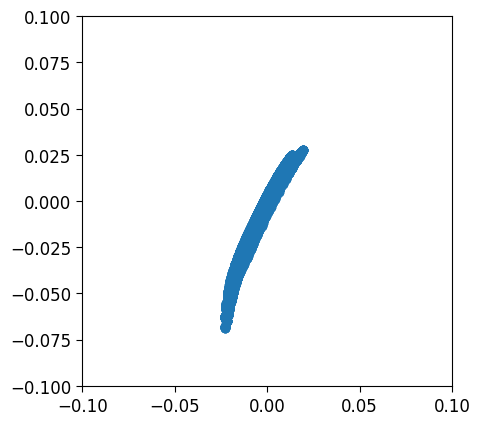

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/test4/20241002-182242dcm-4-w-10000.0-re-True-ptTrue/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 4.0, 'include_pseudotensors': False, 'debug': False}
MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 4
    include_pseudotensors = True
)
1.706163e-06
0.99665385


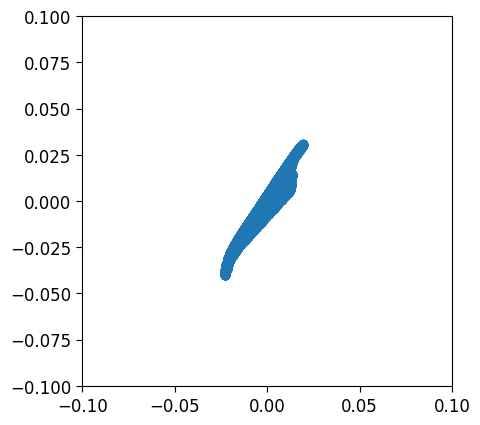

In [301]:
for i in range(len(KEYS)):
    try:
        p = files[KEYS[i]]
        print(p)
        model, params, _ = create_model_and_params(p, debug=False)
        print(model)
        mono, dipo = apply_model(model, params, output[0], 1)
        
        from dcmnet.loss import esp_mono_loss_pots
        
        if model.n_dcm == 1:
            dipo = batch["R"]
        esp_dc_pred = esp_mono_loss_pots(
            dipo, mono.flatten(), batch["vdw_surface"], batch["Z"], batch_size, model.n_dcm
        )
        
        plt.scatter(batch["esp"][mask], esp_dc_pred[0][mask])
        ax = plt.gca()
        ax.set_xlim(-0.1, 0.1)
        ax.set_ylim(-0.1, 0.1)
        ax.set_aspect("equal")
        l2_loss = optax.l2_loss(batch["esp"][mask], esp_dc_pred[0][mask]) * 2
        esp_loss = np.mean(l2_loss) ** 0.5
        pred_D = atom_centered_dipole(dipo, batch["com"], mono.flatten())
        print(pred_D)
        print(esp_loss*627.509)
        plt.show()
        
    except:
        pass

In [315]:
mono[:,:18]

Array([[[ 0.3387727 , -0.3743772 , -0.14710934, -0.03886823],
        [ 0.2266588 , -0.3217329 , -0.11521578, -0.04252717],
        [ 0.32295504, -0.12861504, -0.08686886, -0.02928764],
        [ 0.22542222, -0.32435176, -0.11579396, -0.04297572],
        [ 0.34582803, -0.37473288, -0.1483159 , -0.03706974],
        [ 0.32295486, -0.12861502, -0.08686876, -0.02928763],
        [ 0.3458281 , -0.37473285, -0.14831594, -0.03706975],
        [ 0.22542222, -0.32435176, -0.11579399, -0.0429757 ],
        [ 0.22665884, -0.32173288, -0.11521581, -0.04252717],
        [ 0.33877277, -0.3743772 , -0.14710937, -0.03886824],
        [ 0.24814846,  0.02178937, -0.09888996,  0.04300058],
        [ 0.2797302 ,  0.01378186, -0.11996673,  0.04637083],
        [ 0.28064322,  0.02216558, -0.12900983,  0.0537985 ],
        [ 0.23505135,  0.021476  , -0.08756119,  0.03767708],
        [ 0.23505129,  0.02147606, -0.08756118,  0.03767707],
        [ 0.28064322,  0.02216559, -0.12900986,  0.05379854],
        

In [314]:
mono[:,:18].sum(axis=2)

Array([[-0.22158207, -0.25281703,  0.07818352, -0.25769922, -0.2142905 ,
         0.07818344, -0.21429044, -0.25769922, -0.25281703, -0.22158204,
         0.21404845,  0.21991616,  0.22759748,  0.20664322,  0.20664324,
         0.22759749,  0.21991612,  0.21404845]], dtype=float32)

In [304]:
# plot_model(model, params, output[0], 1, model.n_dcm)
from dcmnet.plotting_3d import plot_3d_models, plot_3d_molecule
from ase.visualize import view
mono.shape

(1, 60, 4)

In [305]:
dipo.shape

(240, 3)

In [317]:
V1, V2, V3, mol, dcmol, combined = plot_3d_models(mono, dipo, np.array([mono.flatten()]), output[0], 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17]),)
72
Atoms(symbols='C10H8He38X34', pbc=False)


In [319]:
view(mol)

<Popen: returncode: None args: ['/pchem-data/meuwly/boittier/home/miniforge3...>

In [308]:
len(dcmol.positions)

72

In [309]:
output[0]["Z"]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [310]:
dipo[:12*3]

Array([[-1.7102463e+00,  1.8148140e+00, -2.5609734e-03],
       [-1.7281549e+00,  1.8384268e+00, -1.3514846e-03],
       [-1.9208539e+00,  2.1469946e+00, -4.2993929e-03],
       [-1.8542641e+00,  1.9890562e+00, -3.1658397e-03],
       [-3.6050907e-01,  1.8117802e+00, -1.9677591e-03],
       [-3.5136008e-01,  1.8425430e+00, -2.3027898e-03],
       [-3.2667768e-01,  2.1001551e+00, -1.3089757e-03],
       [-2.4511096e-01,  1.9171617e+00, -2.9533550e-03],
       [ 3.6081195e-01,  6.0751319e-01, -2.1848488e-03],
       [ 3.5981014e-01,  6.0594267e-01, -2.1135339e-03],
       [ 4.1754609e-01,  7.0167214e-01, -2.2037723e-03],
       [ 3.8546789e-01,  6.4530075e-01, -2.3487490e-03],
       [ 1.7642801e+00,  5.5730313e-01, -7.5188442e-03],
       [ 1.7846521e+00,  5.7813841e-01, -8.3717592e-03],
       [ 1.9946002e+00,  7.1535778e-01, -8.4117539e-03],
       [ 1.8000656e+00,  7.0366484e-01, -8.0141155e-03],
       [-2.4169681e+00,  6.2236243e-01,  9.5837237e-04],
       [-2.4505224e+00,  6.2459

In [311]:
V1, mol = plot_3d_molecule(output[0], 1)

In [312]:
# evaluate_dc(output[0], dipo, mono, 1, model.n_dcm, plot=True, id=False)

In [313]:
output

[{'R': array([[-1.73191642e+00,  1.84071203e+00, -2.20825562e-03],
         [-3.54254897e-01,  1.84071203e+00, -2.20825562e-03],
         [ 3.62937633e-01,  6.11144930e-01, -2.20825562e-03],
         [ 1.78598931e+00,  5.76079545e-01, -7.95511784e-03],
         [-2.45322383e+00,  6.27412889e-01,  4.48742096e-04],
         [-3.62937633e-01, -6.11144930e-01,  2.20825562e-03],
         [ 2.45322383e+00, -6.27412889e-01, -4.48742096e-04],
         [-1.78598931e+00, -5.76079545e-01,  7.95511784e-03],
         [ 3.54254897e-01, -1.84071203e+00,  2.20825562e-03],
         [ 1.73191642e+00, -1.84071203e+00,  2.20825562e-03],
         [-2.23303910e+00,  2.68224316e+00, -1.99430936e-02],
         [ 1.51917721e-01,  2.65461272e+00,  4.89382890e-03],
         [ 2.25256308e+00,  1.40024044e+00, -3.15177821e-03],
         [-3.44285784e+00,  6.30192656e-01,  1.34231038e-02],
         [ 3.44285784e+00, -6.30192656e-01, -1.34231038e-02],
         [-2.25256308e+00, -1.40024044e+00,  3.15177821e-03],
   

10.599367050947498
28.646791


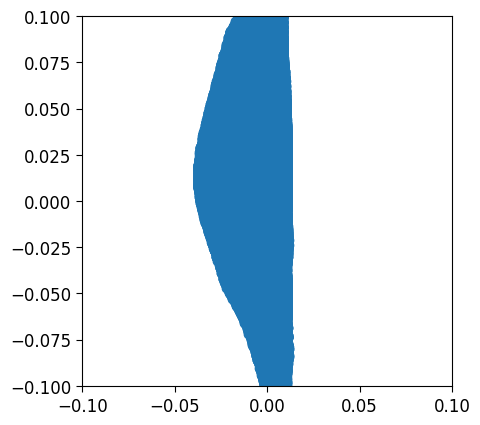

In [222]:
esp_mono_pred = esp_mono_loss_pots(
    batch["R"], batch["mono"], batch["vdw_surface"],  batch["mono"], batch_size, 1
)
plt.scatter(batch["esp"][mask], esp_mono_pred[0][mask])
ax = plt.gca()
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)
ax.set_aspect("equal")
l2_loss = optax.l2_loss(batch["esp"][mask], esp_mono_pred[0][mask]) * 2
esp_loss = np.mean(l2_loss) ** 0.5
pred_D = atom_centered_dipole(batch["R"], batch["com"], batch["mono"])
print(pred_D)
print(esp_loss*627.509)

In [223]:
fn = "/pchem-data/meuwly/boittier/home/jaxeq/eric/fluro/19charges.xyz"
# fn = "/pchem-data/meuwly/boittier/MDCM/examples/methanol/4-fit-molecule/fit1/12charges.xyz"
# fn = "benzene_19.xyz"

In [224]:
dcmXYZ = []
dcmQ = []
with open(Path(fn)) as f:
    lines = f.readlines()
    nlines = int(lines[0])
    for i in range(nlines):
        spl = lines[i+2].split()
        dcmXYZ.append(np.array([float(_) for _ in spl[1:-1]]))
        dcmQ.append(float(spl[-1]))
dcmXYZ = np.array(dcmXYZ)
dcmQ = np.array(dcmQ)

(5176290,)


(-10.0, 10.0)

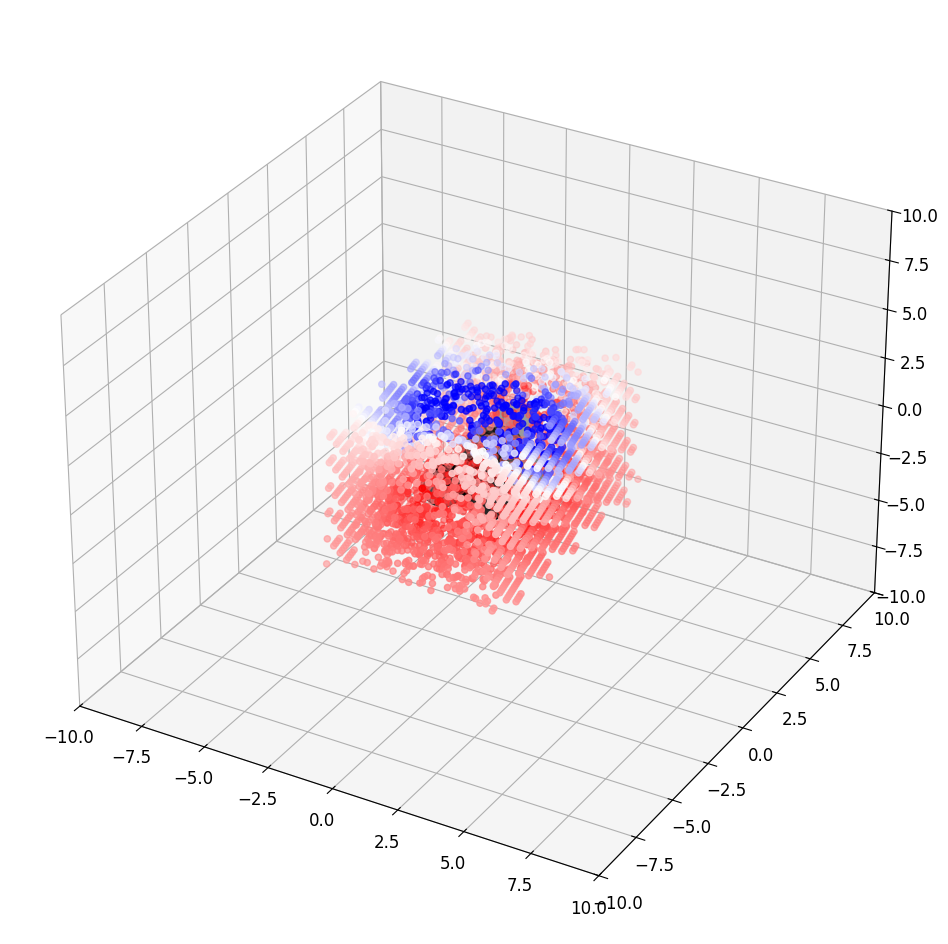

In [225]:
colors = clip_colors(esp_dc_pred[0])
print(colors.shape)
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(111, projection="3d")

ax1.scatter(*XYZ[mask][::1000].T, c=colors[mask][::1000])
ax1.scatter(*R.T, c="k", s=1000)

ax1.set_xlim(-10,10)
ax1.set_ylim(-10,10)
ax1.set_zlim(-10,10)

In [60]:
dcm_pred_esp = calc_esp(dcmXYZ, dcmQ, batch["vdw_surface"])

In [154]:
dcmQ

array([ 0.7692136 , -0.80257024,  0.0136991 , -0.03904142, -0.36540703,
        0.3780226 ,  0.09660081, -0.25730573, -0.8596173 ,  0.99144818,
        0.93355154, -0.88261085, -0.64469784,  0.03204116,  0.44298519,
        0.73955084, -0.82098395,  0.13883096,  0.1362904 ])

In [156]:
from ase import Atoms
dcmol = Atoms(["X" if _ > 0 else "He" for _ in dcmQ], 
              dcmXYZ)

In [158]:
view(dcmol+mol)

<Popen: returncode: None args: ['/pchem-data/meuwly/boittier/home/miniforge3...>

1.5658393341653445
0.3645452


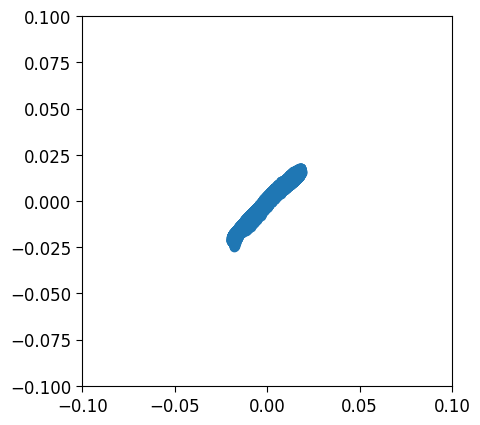

In [61]:
plt.scatter(batch["esp"][mask], dcm_pred_esp[mask])
ax = plt.gca()
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.1, 0.1)
ax.set_aspect("equal")
l2_loss = optax.l2_loss(batch["esp"][mask], dcm_pred_esp[mask]) * 2
esp_loss = np.mean(l2_loss) ** 0.5
pred_D = atom_centered_dipole(dcmXYZ, batch["com"], dcmQ)
print(pred_D)
print(esp_loss*627.509)

In [33]:
pred_D = atom_centered_dipole(dcmXYZ, 0, dcmQ)

In [34]:
pred_D

np.float64(0.028851763324514727)